Loading sample data...
Found 6 files to process
Loading yellow_tripdata_2023-12.parquet
Loading yellow_tripdata_2023-01.parquet
Loading yellow_tripdata_2023-03.parquet
Loading yellow_tripdata_2023-04.parquet
Loading yellow_tripdata_2023-02.parquet
Loading yellow_tripdata_2023-06.parquet
Sample data shape: (193566, 21)

Columns in the dataset:
['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'source_file', 'airport_fee']

Data types:
VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULoc

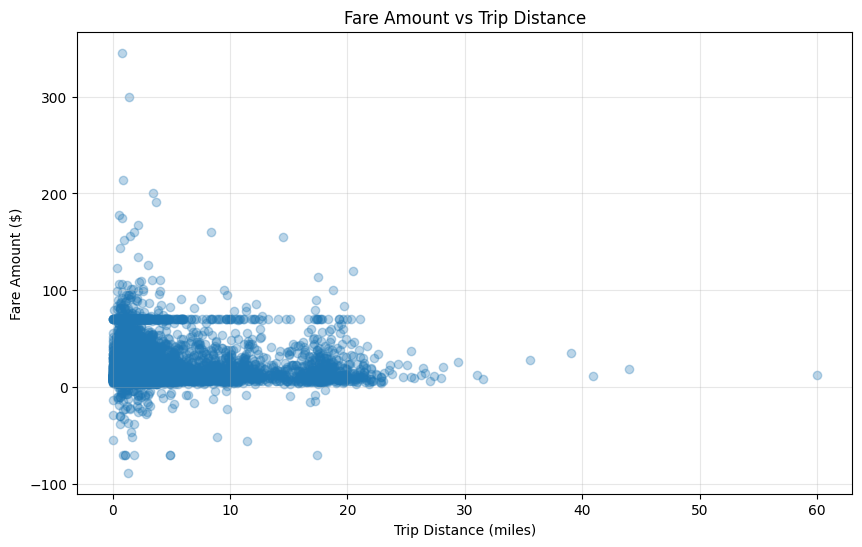

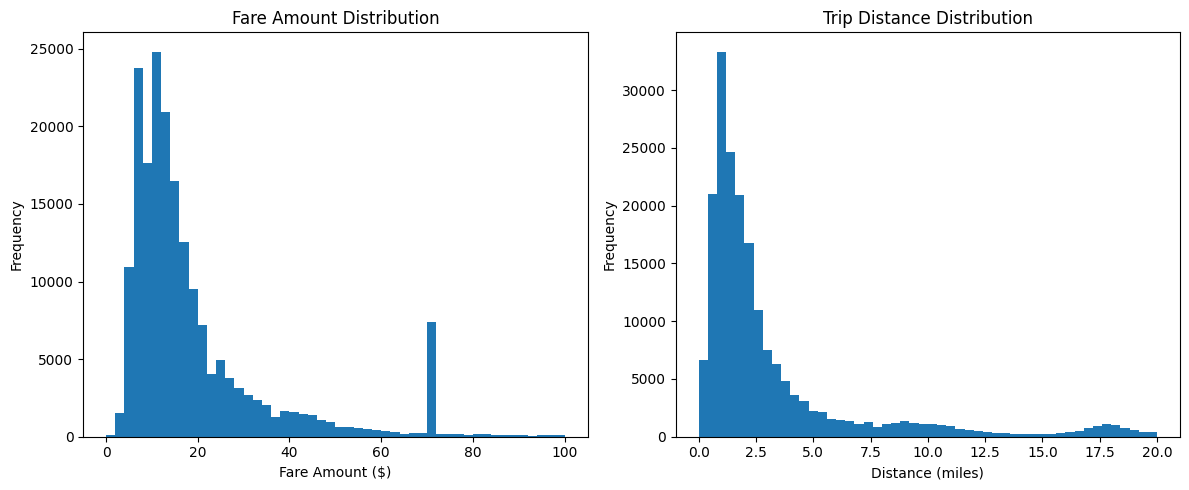

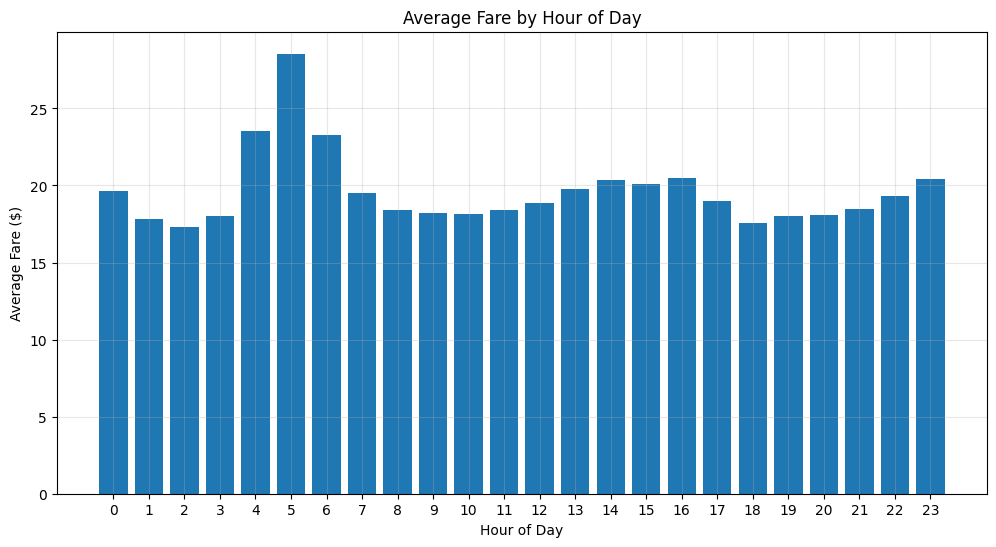

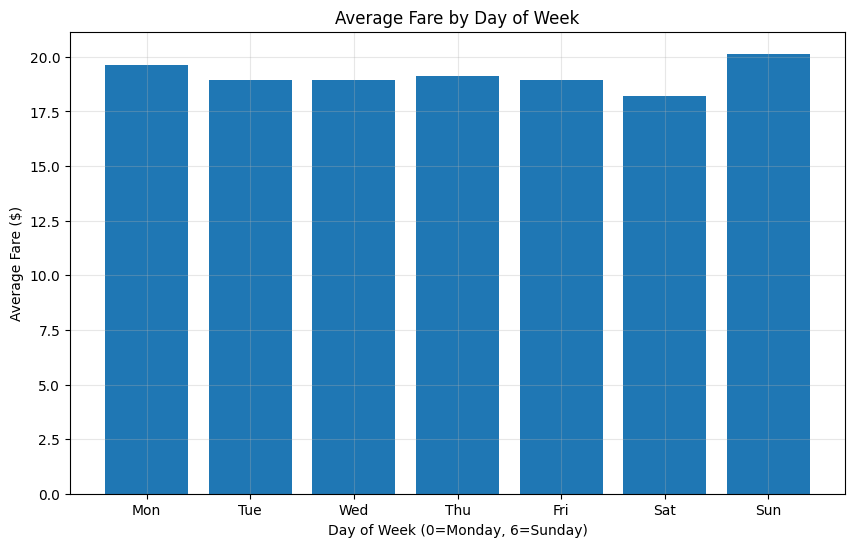

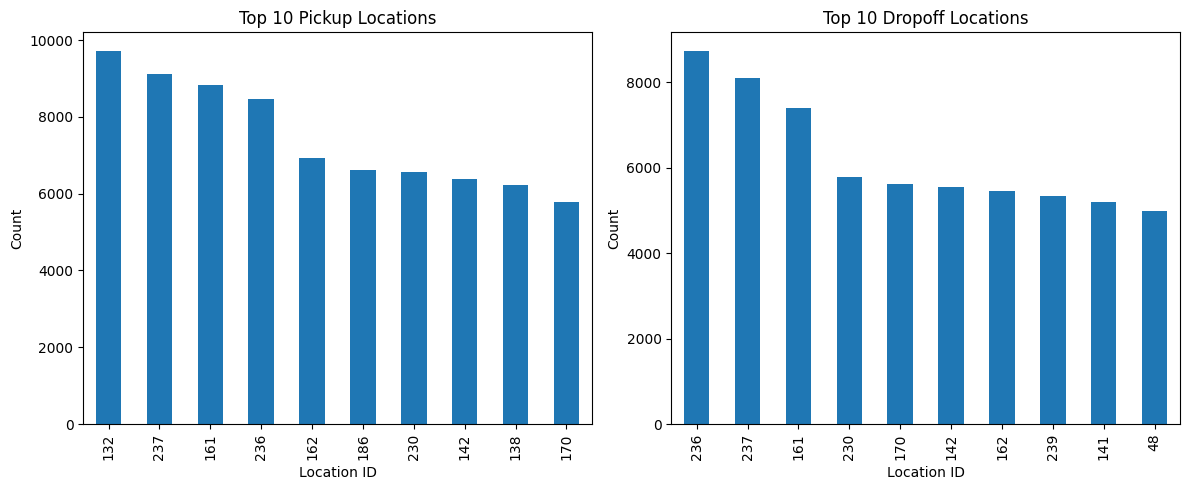

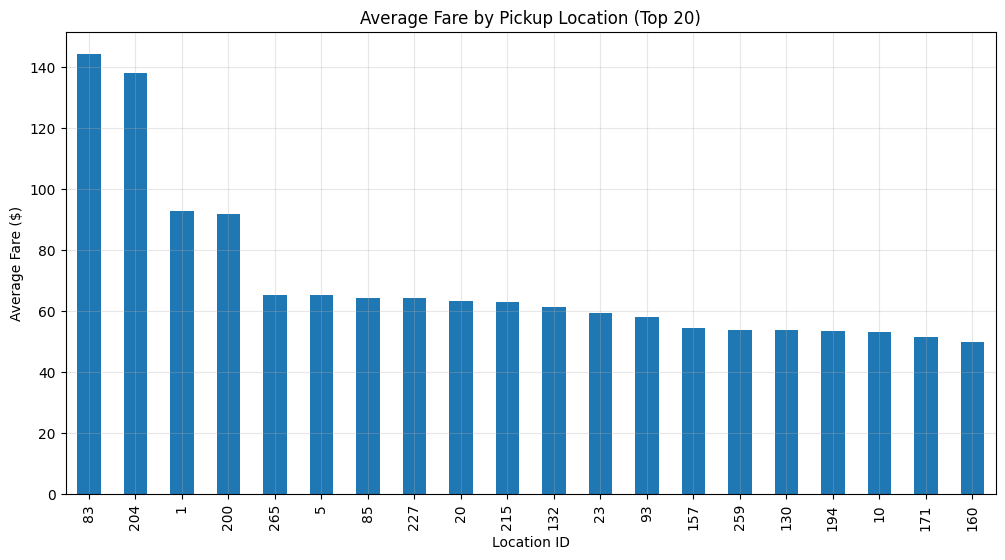


Saving sample data for further processing...
Data exploration complete!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

def load_data(base_path, service_type=None, years=None, months=None, sample_fraction=None):
    """
    Load TLC trip data from multiple parquet files
    
    Parameters:
    - base_path: path to directory containing parquet files
    - service_type: 'yellow', 'green', 'fhv', or 'fhvhv' (None for all types)
    - years: list of years to include (None for all years)
    - months: list of months to include (None for all months)
    - sample_fraction: fraction of data to sample (None for all data)
    
    Returns:
    - DataFrame with combined data
    """
    # Build pattern based on filters
    pattern = f"{base_path}/"
    if service_type:
        pattern += f"{service_type}_tripdata_"
    else:
        pattern += "*_tripdata_"
        
    if years and months:
        patterns = [f"{pattern}{year}-{month:02d}.parquet" for year in years for month in months]
        file_list = []
        for p in patterns:
            file_list.extend(glob.glob(p))
    elif years:
        patterns = [f"{pattern}{year}-*.parquet" for year in years]
        file_list = []
        for p in patterns:
            file_list.extend(glob.glob(p))
    elif months:
        patterns = [f"{pattern}*-{month:02d}.parquet" for month in months]
        file_list = []
        for p in patterns:
            file_list.extend(glob.glob(p))
    else:
        file_list = glob.glob(f"{pattern}*.parquet")
    
    print(f"Found {len(file_list)} files to process")
    
    # Load each file, potentially sampling
    dfs = []
    for file in file_list:
        print(f"Loading {os.path.basename(file)}")
        try:
            if sample_fraction:
                # Reading only a fraction of the data
                df = pd.read_parquet(file).sample(frac=sample_fraction, random_state=42)
            else:
                df = pd.read_parquet(file)
            
            # Add source file info
            df['source_file'] = os.path.basename(file)
            dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
    
    # Combine all dataframes
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()

# Load a sample of the data (adjust years as needed)
print("Loading sample data...")
sample_data = load_data(
    base_path='/kaggle/input/nyc-tlc-trip-record-data-repository',
    service_type='yellow',
    years=[2023],  # Use the most recent data
    sample_fraction=0.01  # Use 1% of the data for exploration
)

print(f"Sample data shape: {sample_data.shape}")
print("\nColumns in the dataset:")
print(sample_data.columns.tolist())

print("\nData types:")
print(sample_data.dtypes)

print("\nSummary statistics:")
print(sample_data.describe())

# Check for missing values
print("\nMissing values:")
print(sample_data.isnull().sum())

# Explore the key columns
print("\nUnique values in categorical columns:")
for col in ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type']:
    if col in sample_data.columns:
        print(f"{col}: {sample_data[col].unique()}")

# Visualize the relationship between trip distance and fare
plt.figure(figsize=(10, 6))
plt.scatter(sample_data['trip_distance'].sample(10000), 
            sample_data['fare_amount'].sample(10000), alpha=0.3)
plt.title('Fare Amount vs Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Fare distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(sample_data['fare_amount'], bins=50, range=(0, 100))
plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sample_data['trip_distance'], bins=50, range=(0, 20))
plt.title('Trip Distance Distribution')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Extract datetime features for analysis
if 'tpep_pickup_datetime' in sample_data.columns:
    sample_data['pickup_hour'] = pd.to_datetime(sample_data['tpep_pickup_datetime']).dt.hour
    sample_data['pickup_day'] = pd.to_datetime(sample_data['tpep_pickup_datetime']).dt.day
    sample_data['pickup_weekday'] = pd.to_datetime(sample_data['tpep_pickup_datetime']).dt.weekday
    
    # Average fare by hour of day
    hour_data = sample_data.groupby('pickup_hour')['fare_amount'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.bar(hour_data['pickup_hour'], hour_data['fare_amount'])
    plt.title('Average Fare by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Fare ($)')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Average fare by day of week
    weekday_data = sample_data.groupby('pickup_weekday')['fare_amount'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(weekday_data['pickup_weekday'], weekday_data['fare_amount'])
    plt.title('Average Fare by Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Average Fare ($)')
    plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True, alpha=0.3)
    plt.show()

# Investigate location patterns
if 'PULocationID' in sample_data.columns and 'DOLocationID' in sample_data.columns:
    # Top pickup locations
    top_pickup = sample_data['PULocationID'].value_counts().head(10)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    top_pickup.plot(kind='bar')
    plt.title('Top 10 Pickup Locations')
    plt.xlabel('Location ID')
    plt.ylabel('Count')
    
    # Top dropoff locations
    top_dropoff = sample_data['DOLocationID'].value_counts().head(10)
    
    plt.subplot(1, 2, 2)
    top_dropoff.plot(kind='bar')
    plt.title('Top 10 Dropoff Locations')
    plt.xlabel('Location ID')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Average fare by pickup location (top 20)
    location_fare = sample_data.groupby('PULocationID')['fare_amount'].mean().sort_values(ascending=False).head(20)
    
    plt.figure(figsize=(12, 6))
    location_fare.plot(kind='bar')
    plt.title('Average Fare by Pickup Location (Top 20)')
    plt.xlabel('Location ID')
    plt.ylabel('Average Fare ($)')
    plt.grid(True, alpha=0.3)
    plt.show()

# Save a sample for further processing
print("\nSaving sample data for further processing...")
sample_data.to_csv('sample_taxi_data.csv', index=False)

print("Data exploration complete!")


Loading sample data...
Data shape: (193566, 24)

=== Data Cleaning ===
Filtering out invalid fare amounts...
Filtering out invalid distances...
Data shape after basic cleaning: (180412, 24)

=== Feature Engineering ===
Creating time-based features...
Calculating trip duration...
Calculating average speed...
Creating location-based features...
Data shape after feature engineering: (180333, 40)

Final feature set: ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_weekday', 'is_weekend', 'is_rush_hour', 'trip_duration', 'avg_speed', 'PULocationID', 'DOLocationID', 'pickup_is_airport', 'dropoff_is_airport', 'same_location', 'is_credit_card', 'rate_1.0', 'rate_2.0', 'rate_3.0', 'rate_4.0', 'rate_5.0', 'rate_99.0']

=== Preparing Data for Modeling ===
Handling missing values...
Saving processed data...

=== Visualizing Engineered Features ===


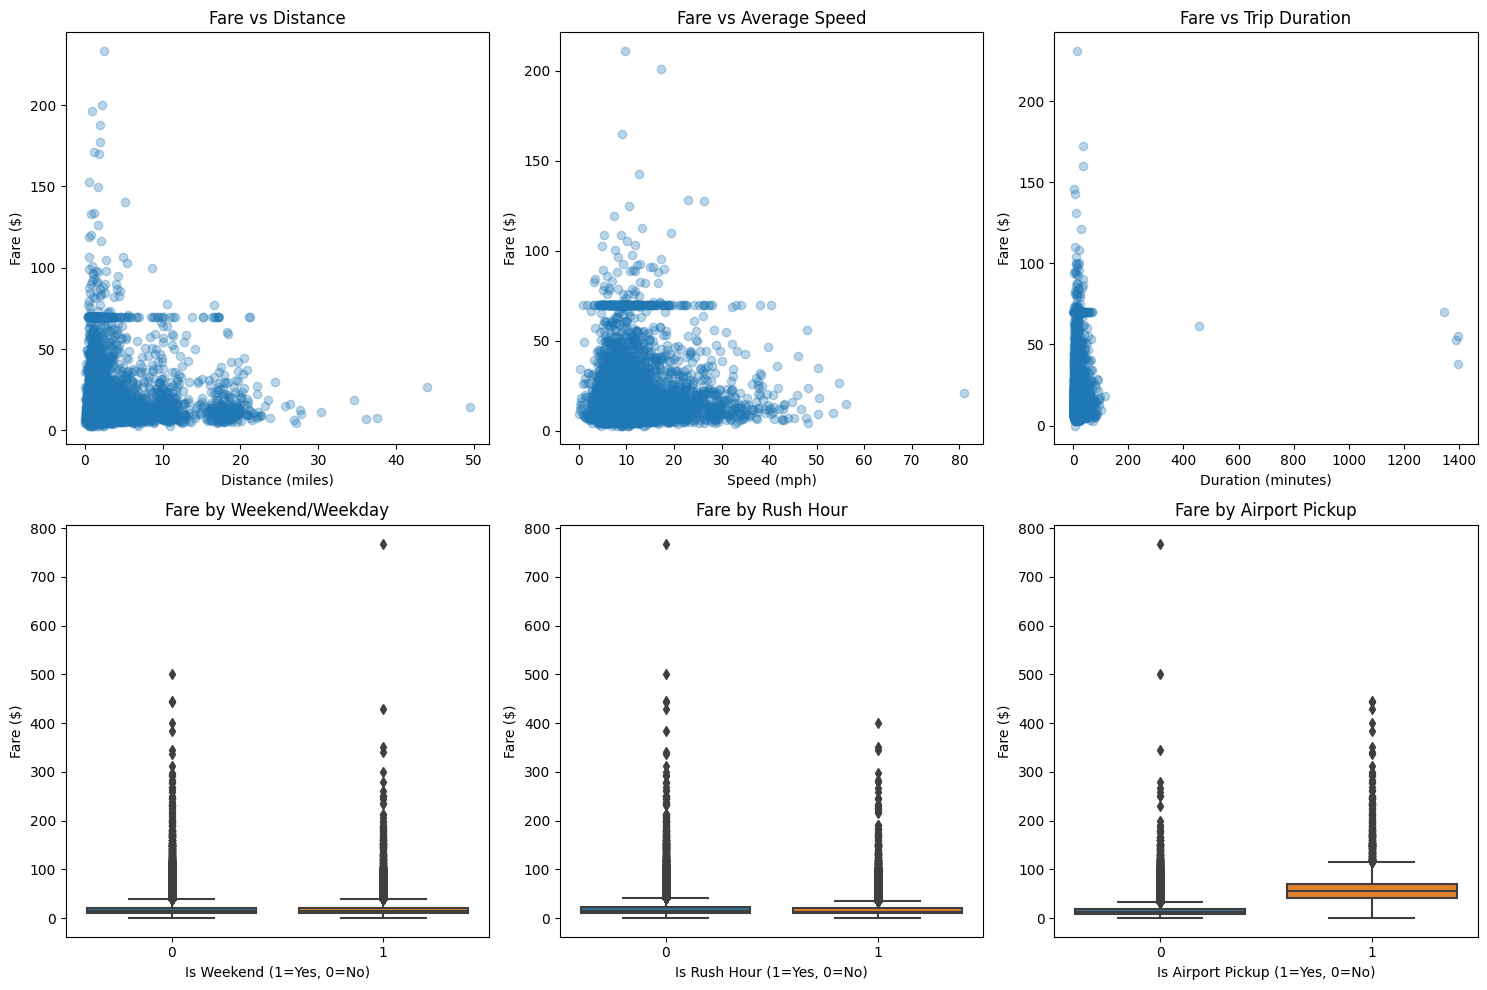

Data preprocessing complete!


In [2]:
import seaborn as sns

# Load the sample data from the previous step
print("Loading sample data...")
df = pd.read_csv('sample_taxi_data.csv')

print(f"Data shape: {df.shape}")

# Basic data cleaning
print("\n=== Data Cleaning ===")

# Convert datetime columns
if 'tpep_pickup_datetime' in df.columns:
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
elif 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Remove invalid fares
print("Filtering out invalid fare amounts...")
df = df[df['fare_amount'] > 0]
df = df[df['fare_amount'] < 1000]  # Remove extreme outliers

# Clean distance
print("Filtering out invalid distances...")
df = df[df['trip_distance'] > 0]
df = df[df['trip_distance'] < 100]  # Filter out unrealistically long trips

# Remove invalid passenger counts
if 'passenger_count' in df.columns:
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 8)]

print(f"Data shape after basic cleaning: {df.shape}")

# Feature Engineering
print("\n=== Feature Engineering ===")

# Extract datetime features
print("Creating time-based features...")
if 'tpep_pickup_datetime' in df.columns:
    pickup_col = 'tpep_pickup_datetime'
    dropoff_col = 'tpep_dropoff_datetime'
elif 'pickup_datetime' in df.columns:
    pickup_col = 'pickup_datetime'
    dropoff_col = 'dropoff_datetime'
else:
    raise ValueError("Datetime columns not found")

df['pickup_hour'] = df[pickup_col].dt.hour
df['pickup_day'] = df[pickup_col].dt.day
df['pickup_month'] = df[pickup_col].dt.month
df['pickup_year'] = df[pickup_col].dt.year
df['pickup_weekday'] = df[pickup_col].dt.weekday
df['is_weekend'] = (df['pickup_weekday'] >= 5).astype(int)
df['is_rush_hour'] = (((df['pickup_hour'] >= 7) & (df['pickup_hour'] <= 10)) | 
                      ((df['pickup_hour'] >= 16) & (df['pickup_hour'] <= 19)) &
                      (df['pickup_weekday'] < 5)).astype(int)

# Calculate trip duration in minutes
print("Calculating trip duration...")
df['trip_duration'] = (df[dropoff_col] - df[pickup_col]).dt.total_seconds() / 60
df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 24*60)]  # Less than 24 hours

# Calculate average speed (mph)
print("Calculating average speed...")
df['avg_speed'] = df['trip_distance'] / (df['trip_duration'] / 60)
df = df[(df['avg_speed'] > 0) & (df['avg_speed'] < 100)]  # Filter out unrealistic speeds

# Location features
print("Creating location-based features...")
if 'PULocationID' in df.columns and 'DOLocationID' in df.columns:
    # Check if the pickup/dropoff is at an airport (JFK=132, LaGuardia=138)
    df['pickup_is_airport'] = df['PULocationID'].isin([132, 138]).astype(int)
    df['dropoff_is_airport'] = df['DOLocationID'].isin([132, 138]).astype(int)
    
    # Same location pickup and dropoff
    df['same_location'] = (df['PULocationID'] == df['DOLocationID']).astype(int)

# Payment type feature
if 'payment_type' in df.columns:
    df['is_credit_card'] = (df['payment_type'] == 1).astype(int)

# Convert RatecodeID to dummy variables
if 'RatecodeID' in df.columns:
    rate_dummies = pd.get_dummies(df['RatecodeID'], prefix='rate')
    df = pd.concat([df, rate_dummies], axis=1)

print(f"Data shape after feature engineering: {df.shape}")

# Create final feature set
feature_cols = [
    'trip_distance',
    'passenger_count',
    'pickup_hour',
    'pickup_weekday',
    'is_weekend',
    'is_rush_hour',
    'trip_duration',
    'avg_speed'
]

# Add location features if available
if 'PULocationID' in df.columns:
    feature_cols.extend(['PULocationID', 'DOLocationID', 'pickup_is_airport', 'dropoff_is_airport', 'same_location'])

# Add payment features if available
if 'is_credit_card' in df.columns:
    feature_cols.append('is_credit_card')

# Add rate code dummies if available
if 'RatecodeID' in df.columns:
    rate_cols = [col for col in df.columns if col.startswith('rate_')]
    feature_cols.extend(rate_cols)

# Ensure all selected features exist in the dataframe
feature_cols = [col for col in feature_cols if col in df.columns]

print(f"\nFinal feature set: {feature_cols}")

# Prepare data for modeling
print("\n=== Preparing Data for Modeling ===")
X = df[feature_cols].copy()
y = df['fare_amount']

# Handle missing values
print("Handling missing values...")
X = X.fillna(X.mean())

# Save processed data
print("Saving processed data...")
X.to_csv('X_features.csv', index=False)
y.to_csv('y_target.csv', index=False)

# Visualize the engineered features
print("\n=== Visualizing Engineered Features ===")

plt.figure(figsize=(15, 10))

# Trip distance vs fare
plt.subplot(2, 3, 1)
plt.scatter(X['trip_distance'].sample(5000), y.sample(5000), alpha=0.3)
plt.title('Fare vs Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Fare ($)')

# Average speed vs fare
plt.subplot(2, 3, 2)
plt.scatter(X['avg_speed'].sample(5000), y.sample(5000), alpha=0.3)
plt.title('Fare vs Average Speed')
plt.xlabel('Speed (mph)')
plt.ylabel('Fare ($)')

# Trip duration vs fare
plt.subplot(2, 3, 3)
plt.scatter(X['trip_duration'].sample(5000), y.sample(5000), alpha=0.3)
plt.title('Fare vs Trip Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Fare ($)')

# Weekend vs fare
if 'is_weekend' in X.columns:
    plt.subplot(2, 3, 4)
    sns.boxplot(x='is_weekend', y=y, data=pd.concat([X['is_weekend'], y], axis=1))
    plt.title('Fare by Weekend/Weekday')
    plt.xlabel('Is Weekend (1=Yes, 0=No)')
    plt.ylabel('Fare ($)')

# Rush hour vs fare
if 'is_rush_hour' in X.columns:
    plt.subplot(2, 3, 5)
    sns.boxplot(x='is_rush_hour', y=y, data=pd.concat([X['is_rush_hour'], y], axis=1))
    plt.title('Fare by Rush Hour')
    plt.xlabel('Is Rush Hour (1=Yes, 0=No)')
    plt.ylabel('Fare ($)')

# Airport pickup vs fare
if 'pickup_is_airport' in X.columns:
    plt.subplot(2, 3, 6)
    sns.boxplot(x='pickup_is_airport', y=y, data=pd.concat([X['pickup_is_airport'], y], axis=1))
    plt.title('Fare by Airport Pickup')
    plt.xlabel('Is Airport Pickup (1=Yes, 0=No)')
    plt.ylabel('Fare ($)')

plt.tight_layout()
plt.show()

print("Data preprocessing complete!")

Loading preprocessed data...
Feature shape: (180333, 20)
Target shape: (180333,)

=== Splitting Data ===
Training set: 144266 samples
Test set: 36067 samples

=== Training Random Forest Model ===
Training model...
Training completed in 23.50 seconds

=== Evaluating Model ===
Mean Squared Error (MSE): 23.2846
Root Mean Squared Error (RMSE): 4.8254
Mean Absolute Error (MAE): 0.6629
R² Score: 0.9270

=== Feature Importance Analysis ===
Top 10 most important features:
          Feature  Importance
0   trip_distance    0.832952
6   trip_duration    0.120524
14       rate_1.0    0.019139
9    DOLocationID    0.010049
15       rate_2.0    0.004175
19      rate_99.0    0.003969
17       rate_4.0    0.001923
7       avg_speed    0.001833
18       rate_5.0    0.001267
2     pickup_hour    0.000996


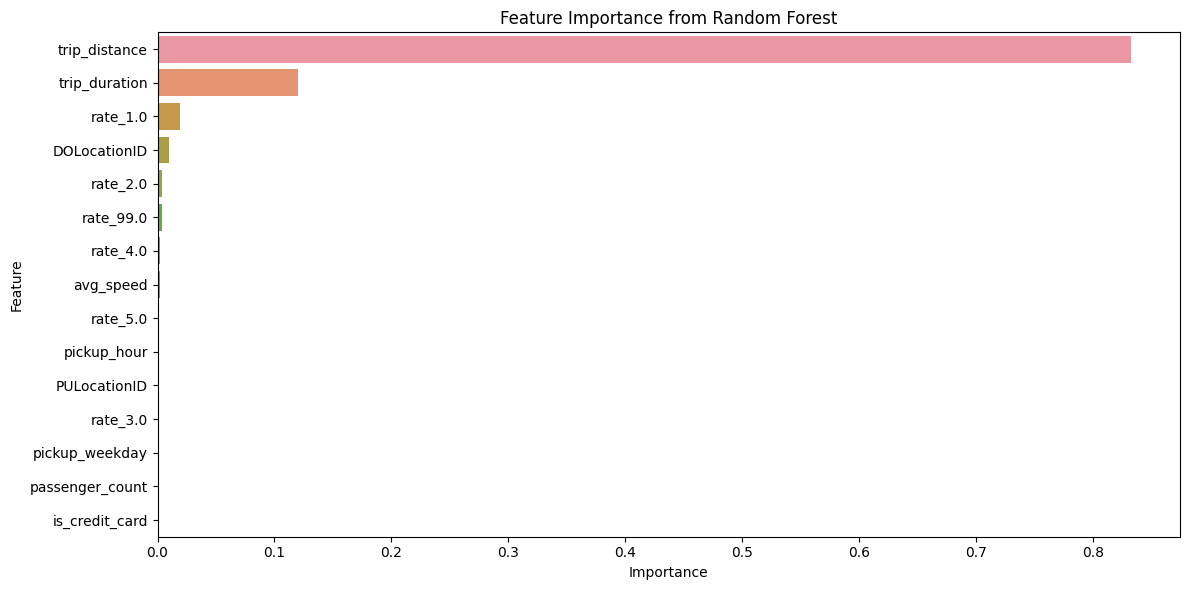

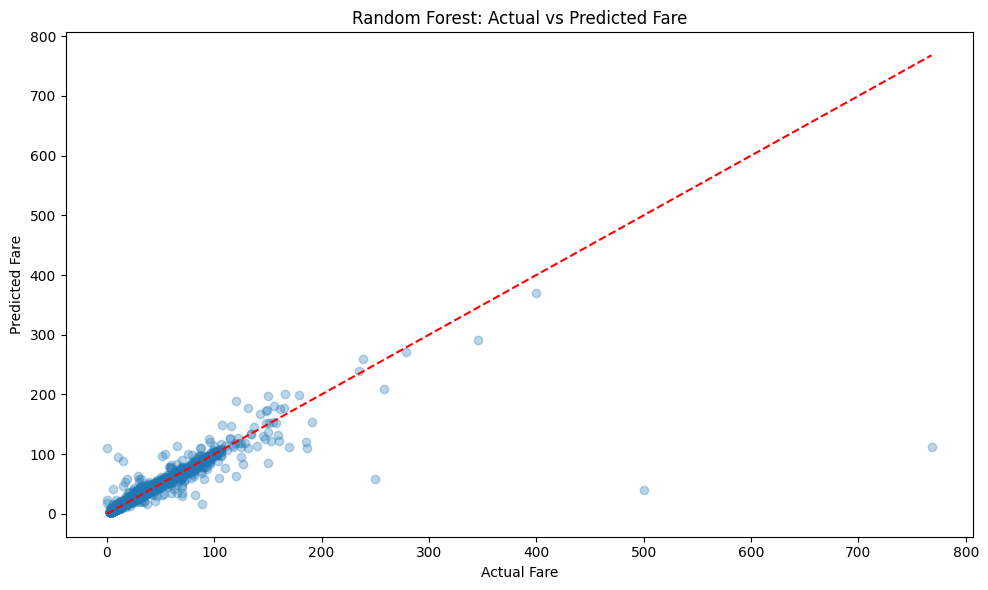

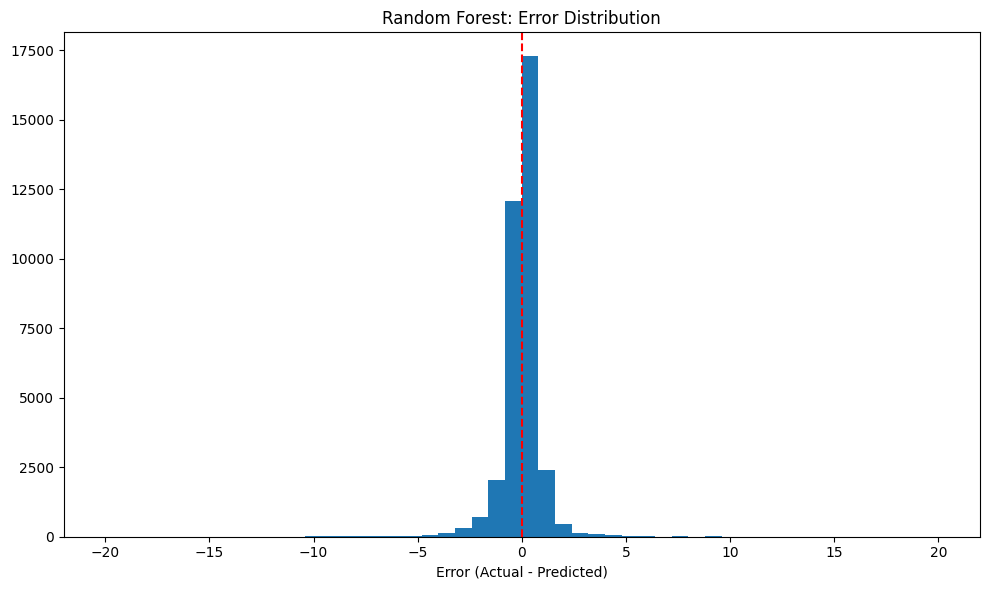


=== Saving Model ===
Random Forest model implementation complete!


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import joblib

# Load preprocessed data
print("Loading preprocessed data...")
X = pd.read_csv('X_features.csv')
y = pd.read_csv('y_target.csv', header=0).iloc[:, 0]  # Get the fare amount column

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data into training and testing sets
print("\n=== Splitting Data ===")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train Random Forest model
print("\n=== Training Random Forest Model ===")
start_time = time.time()

# Initialize model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train model
print("Training model...")
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions on test set
print("\n=== Evaluating Model ===")
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance analysis
print("\n=== Feature Importance Analysis ===")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Random Forest: Actual vs Predicted Fare')
plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(10, 6))
errors = y_test - y_pred
plt.hist(errors, bins=50, range=(-20, 20))
plt.title('Random Forest: Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Save model and predictions
print("\n=== Saving Model ===")
joblib.dump(rf_model, 'random_forest_model.pkl')
pd.DataFrame({'actual': y_test, 'predicted': y_pred}).to_csv('rf_predictions.csv', index=False)
feature_importance.to_csv('rf_feature_importance.csv', index=False)

print("Random Forest model implementation complete!")

Loading preprocessed data...
Feature shape: (180333, 20)
Target shape: (180333,)

=== Splitting Data ===
Training set: 144266 samples
Test set: 36067 samples

=== Training Decision Tree Model ===
Training model...
Training completed in 0.69 seconds

=== Evaluating Model ===
Mean Squared Error (MSE): 24.2644
Root Mean Squared Error (RMSE): 4.9259
Mean Absolute Error (MAE): 0.8015
R² Score: 0.9239

=== Feature Importance Analysis ===
Top 10 most important features:
          Feature  Importance
0   trip_distance    0.837408
6   trip_duration    0.119101
14       rate_1.0    0.019232
9    DOLocationID    0.011066
19      rate_99.0    0.003867
15       rate_2.0    0.003631
17       rate_4.0    0.001388
18       rate_5.0    0.001326
7       avg_speed    0.001298
8    PULocationID    0.000639


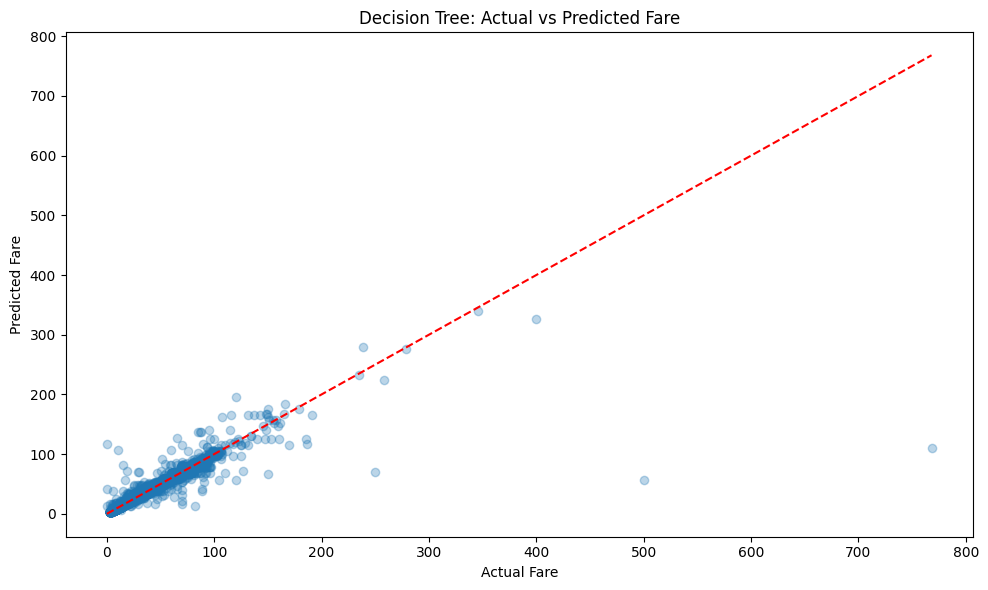

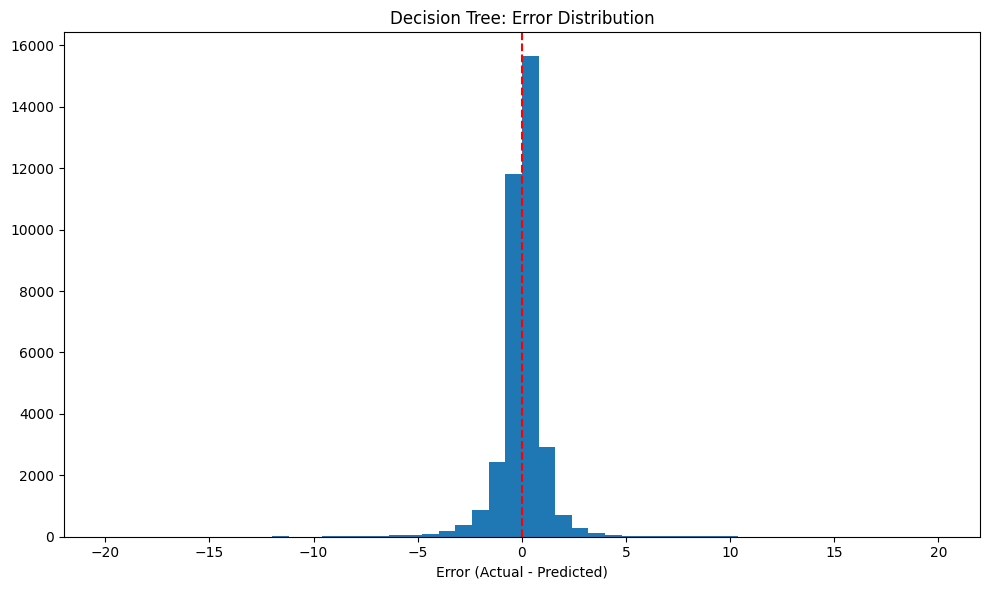


=== Saving Model ===
Decision Tree model implementation complete!


In [4]:
from sklearn.tree import DecisionTreeRegressor

# Load preprocessed data
print("Loading preprocessed data...")
X = pd.read_csv('X_features.csv')
y = pd.read_csv('y_target.csv', header=0).iloc[:, 0]  # Get the fare amount column

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data into training and testing sets
print("\n=== Splitting Data ===")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train Decision Tree model
print("\n=== Training Decision Tree Model ===")
start_time = time.time()

# Initialize model
dt_model = DecisionTreeRegressor(
    max_depth=10,  # Limit depth to prevent overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Train model
print("Training model...")
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions on test set
print("\n=== Evaluating Model ===")
y_pred = dt_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance analysis
print("\n=== Feature Importance Analysis ===")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance.head(10))

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Decision Tree: Actual vs Predicted Fare')
plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(10, 6))
errors = y_test - y_pred
plt.hist(errors, bins=50, range=(-20, 20))
plt.title('Decision Tree: Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Save model and predictions
print("\n=== Saving Model ===")
joblib.dump(dt_model, 'decision_tree_model.pkl')
pd.DataFrame({'actual': y_test, 'predicted': y_pred}).to_csv('dt_predictions.csv', index=False)

print("Decision Tree model implementation complete!")

2025-04-22 20:35:49.074918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745354149.265246      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745354149.319803      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading preprocessed data...
Feature shape: (180333, 20)
Target shape: (180333,)

=== Splitting Data ===
Training set: 144266 samples
Test set: 36067 samples

=== Scaling Features ===

=== Preparing Data for LSTM ===
LSTM input shape: (144266, 1, 20)

=== Building LSTM Model ===


I0000 00:00:1745354162.253461      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          21,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,721 (135.63 KB)

 Trainable params: 34,721 (135.63 KB)

 Non-trainable params: 0 (0.00 B)


=== Training LSTM Model ===
Epoch 1/50


I0000 00:00:1745354167.601905      89 cuda_dnn.cc:529] Loaded cuDNN version 90300


3607/3607 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 146.3181 - mae: 5.4659 - val_loss: 14.7364 - val_mae: 1.0790
Epoch 2/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 17.5105 - mae: 1.6161 - val_loss: 8.8579 - val_mae: 0.9177
Epoch 3/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 13.1702 - mae: 1.4511 - val_loss: 7.6250 - val_mae: 0.8908
Epoch 4/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 10.5899 - mae: 1.4234 - val_loss: 8.5494 - val_mae: 1.0717
Epoch 5/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 9.8179 - mae: 1.3995 - val_loss: 6.3757 - val_mae: 0.8033
Epoch 6/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 9.3647 - mae: 1.3942 - val_loss: 6.0004 - val_mae: 0.8286
Epoch 7/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 8.6564 - mae: 1.3765 - val_loss: 6.3805 - val_mae: 0.8030
Epoch 8/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 8.1196 - mae: 1.3480 - val_loss: 5.5388 - val_mae: 0.8077
Epoch 9/50
3607/3607 ━━━━━━━━━━━━━━━━

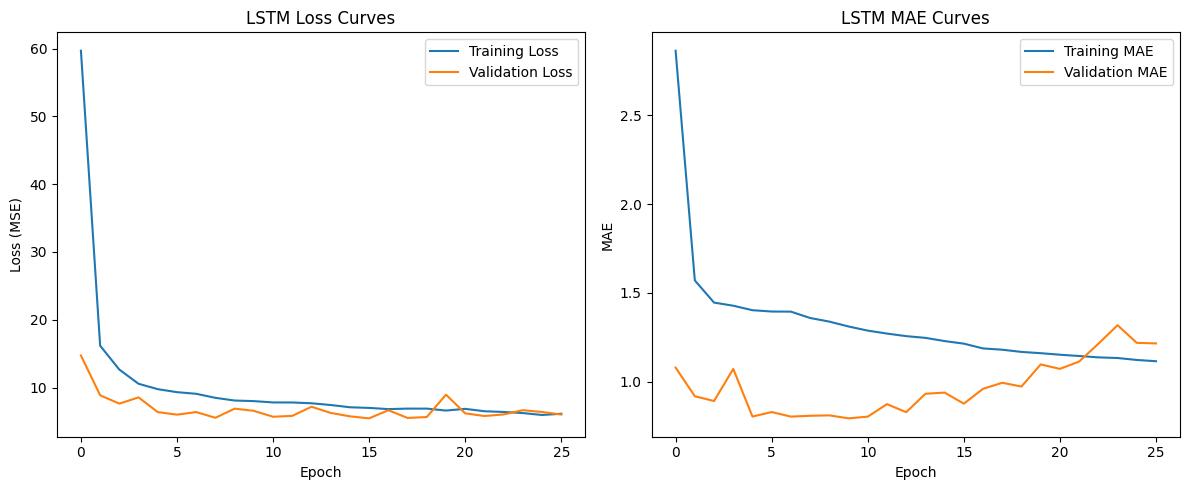

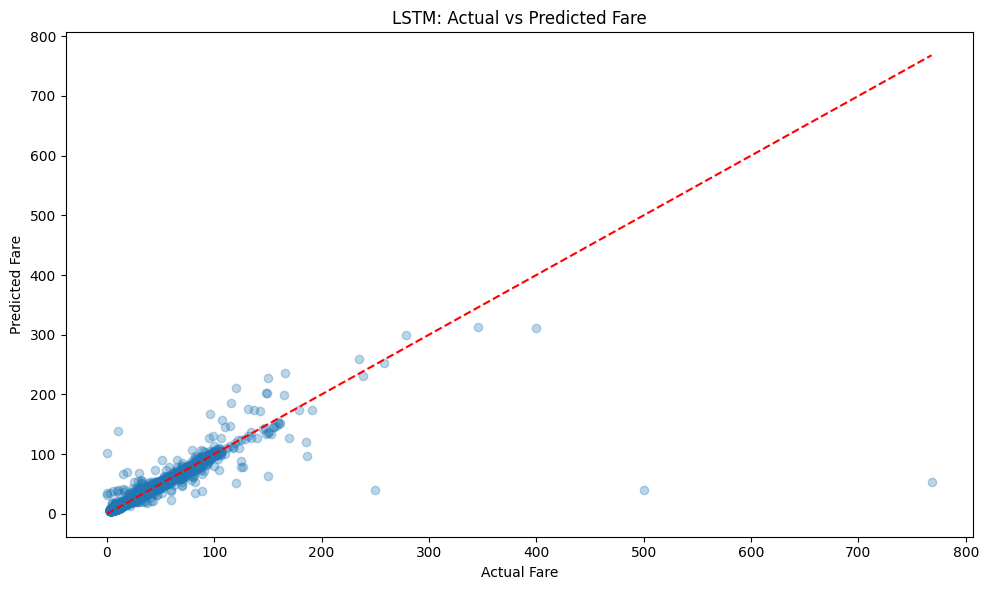

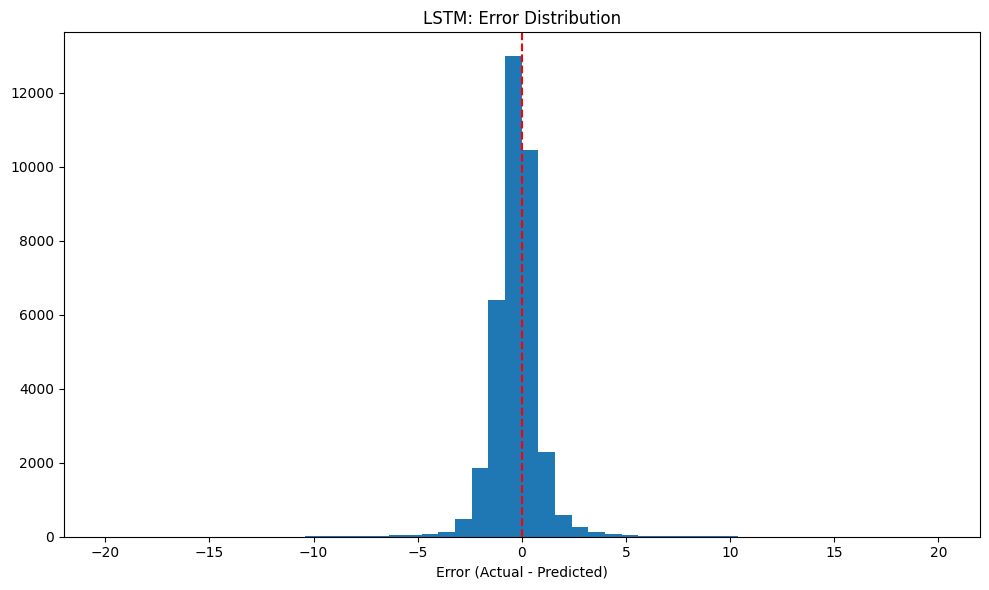


=== Saving Model ===
LSTM model implementation complete!


In [5]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

warnings.filterwarnings('ignore')

# Load preprocessed data
print("Loading preprocessed data...")
X = pd.read_csv('X_features.csv')
y = pd.read_csv('y_target.csv', header=0).iloc[:, 0]  # Get the fare amount column

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data into training and testing sets
print("\n=== Splitting Data ===")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features
print("\n=== Scaling Features ===")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for future use
joblib.dump(scaler, 'lstm_scaler.pkl')

# Reshape data for LSTM (samples, timesteps, features)
print("\n=== Preparing Data for LSTM ===")
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print(f"LSTM input shape: {X_train_lstm.shape}")

# Define LSTM model
print("\n=== Building LSTM Model ===")
lstm_model = Sequential([
    LSTM(64, input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer (no activation for regression)
])

# Compile model
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Model summary
lstm_model.summary()

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train model
print("\n=== Training LSTM Model ===")
start_time = time.time()

history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
print("\n=== Evaluating Model ===")
y_pred = lstm_model.predict(X_test_lstm).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('LSTM: Actual vs Predicted Fare')
plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(10, 6))
errors = y_test - y_pred
plt.hist(errors, bins=50, range=(-20, 20))
plt.title('LSTM: Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Save model and predictions
print("\n=== Saving Model ===")
lstm_model.save('lstm_model.h5')
pd.DataFrame({'actual': y_test, 'predicted': y_pred}).to_csv('lstm_predictions.csv', index=False)

print("LSTM model implementation complete!")

Loading model predictions...
Verifying prediction alignment...

=== Individual Model Performance ===
Decision Tree:
  RMSE: 4.9259
  MAE: 0.8015
  R²: 0.9239
Random Forest:
  RMSE: 4.8254
  MAE: 0.6629
  R²: 0.9270
LSTM:
  RMSE: 5.2084
  MAE: 0.9139
  R²: 0.9149

Model Performance Summary:
           model        mse      rmse       mae        r2
0  Decision Tree  24.264371  4.925888  0.801541  0.923914
1  Random Forest  23.284567  4.825408  0.662884  0.926987
2           LSTM  27.126952  5.208354  0.913884  0.914938

=== Creating Ensemble Model ===
Ensemble weights:
  Decision Tree: 0.3340
  Random Forest: 0.3352
  LSTM: 0.3308

Ensemble Model Performance:
  RMSE: 4.9043
  MAE: 0.7215
  R²: 0.9246


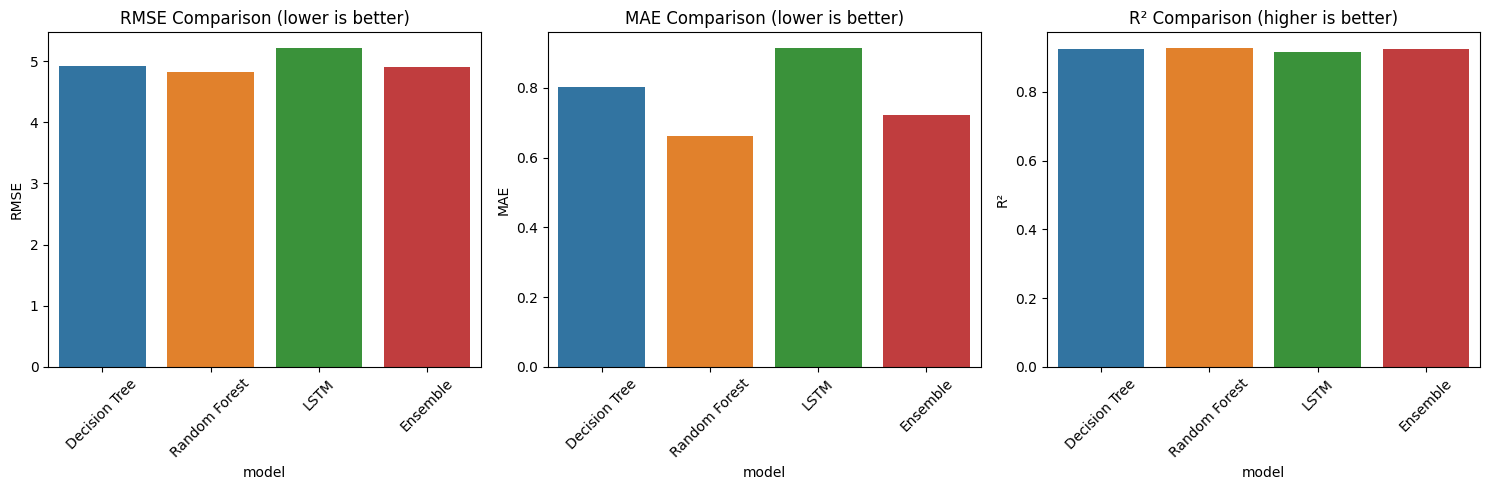

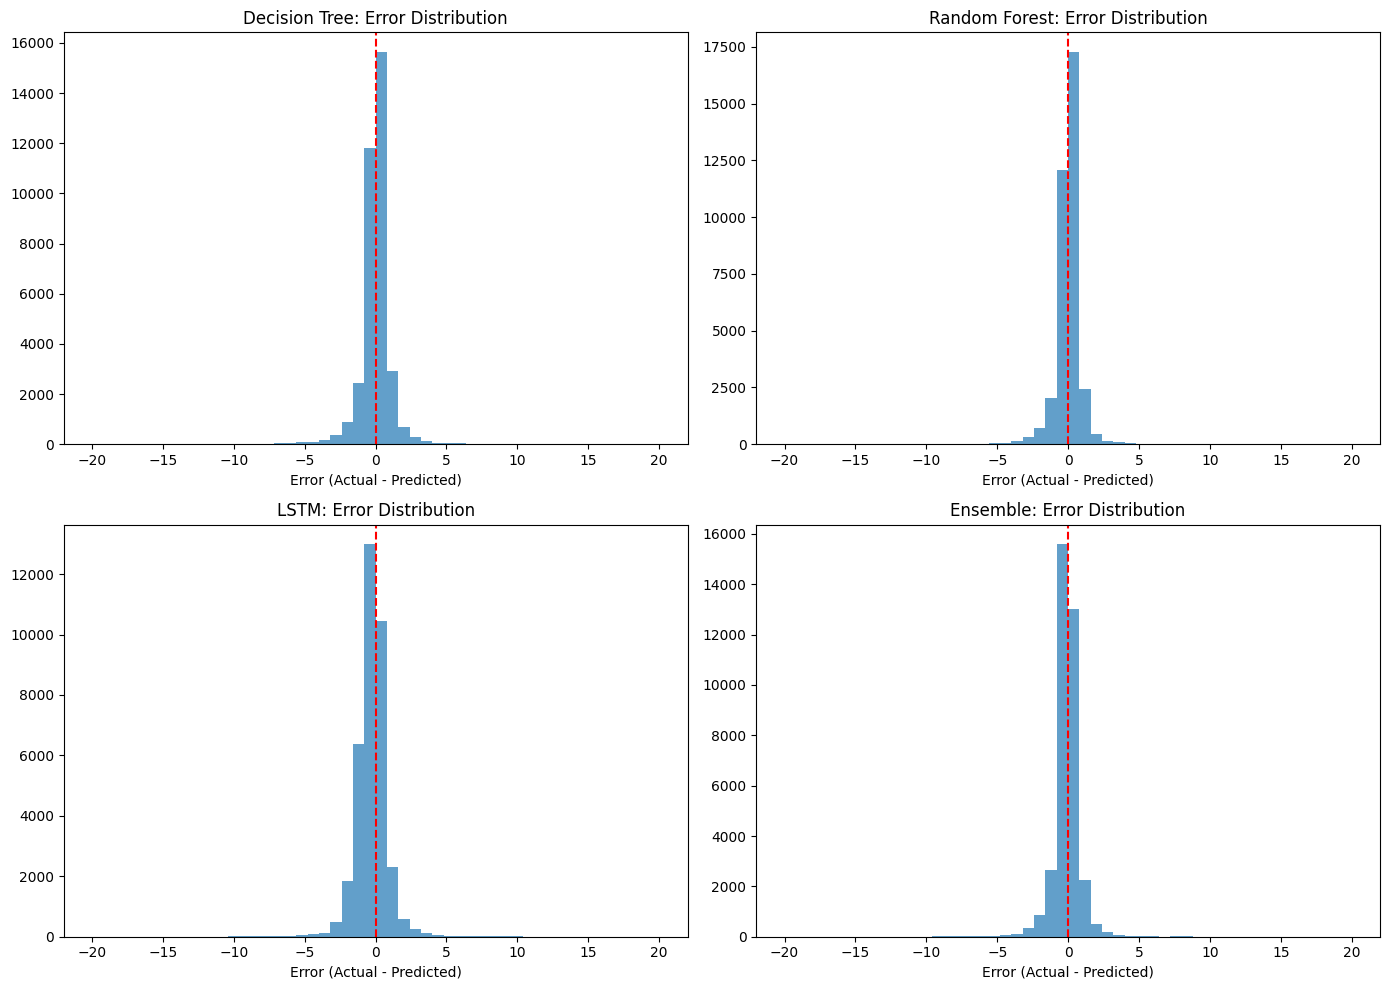

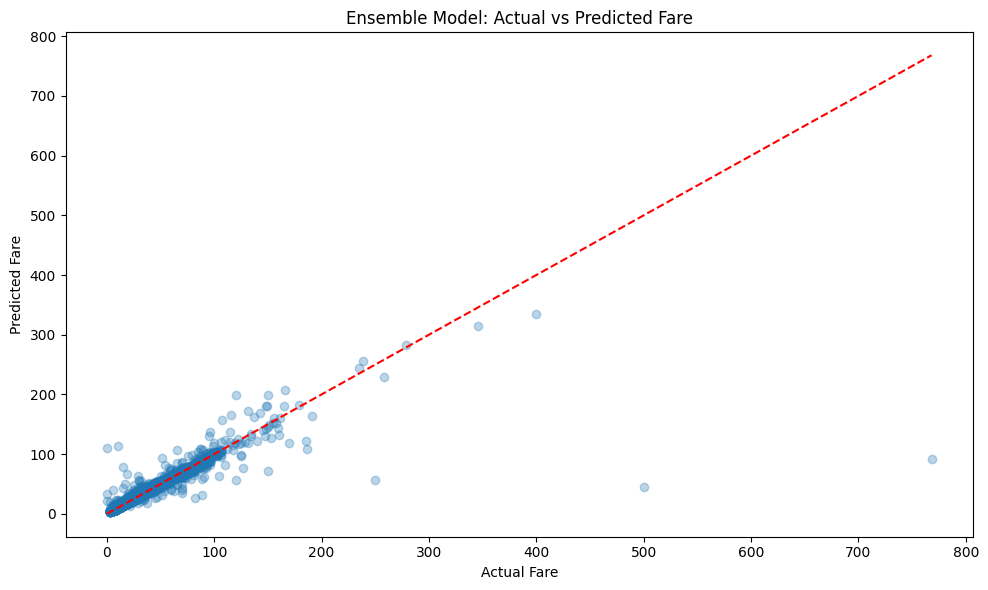


Mean Absolute Error by Fare Range:
               Actual  DT_Error  RF_Error  LSTM_Error  Ensemble_Error
Fare_Group                                                           
(0, 10]      7.700565  0.369017  0.311262    0.753149        0.410829
(10, 20]    14.308922  0.575244  0.503892    0.551515        0.507561
(20, 30]    24.237879  1.014566  0.840663    0.901353        0.858045
(30, 40]    34.287587  1.415516  1.102349    1.265495        1.130859
(40, 50]    44.391617  1.603329  1.283401    1.606421        1.356977
(50, 100]   68.190780  2.020669  1.307421    2.077090        1.587545


<Figure size 1200x600 with 0 Axes>

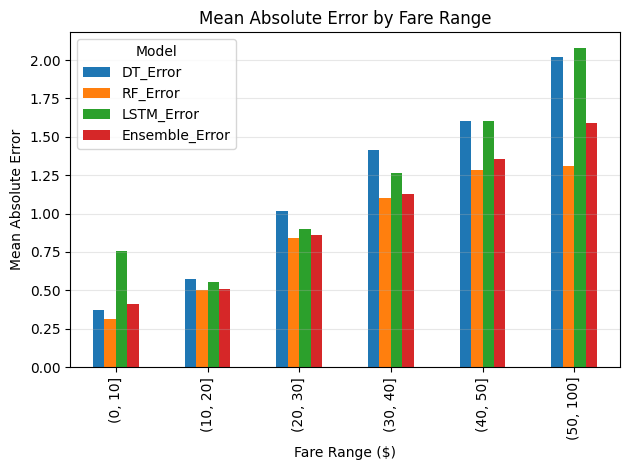

Model comparison and ensemble creation complete!


In [6]:
# Load prediction results from each model
print("Loading model predictions...")
dt_preds = pd.read_csv('dt_predictions.csv')
rf_preds = pd.read_csv('rf_predictions.csv')
lstm_preds = pd.read_csv('lstm_predictions.csv')

# Ensure we're working with the same test samples for each model
print("Verifying prediction alignment...")
assert dt_preds.shape[0] == rf_preds.shape[0] == lstm_preds.shape[0], "Prediction sizes don't match"

# Compute metrics for each model
print("\n=== Individual Model Performance ===")
models = ["Decision Tree", "Random Forest", "LSTM"]
results = []

for model_name, preds_df in zip(models, [dt_preds, rf_preds, lstm_preds]):
    actual = preds_df['actual']
    pred = preds_df['predicted']
    
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    
    results.append({
        'model': model_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })
    
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df)

# Create ensemble model
print("\n=== Creating Ensemble Model ===")

# Calculate weights based on R² score (better models get higher weights)
r2_sum = results_df['r2'].sum()
weights = results_df['r2'] / r2_sum

print("Ensemble weights:")
for model, weight in zip(models, weights):
    print(f"  {model}: {weight:.4f}")

# Create weighted ensemble predictions
ensemble_pred = (
    weights[0] * dt_preds['predicted'] +
    weights[1] * rf_preds['predicted'] +
    weights[2] * lstm_preds['predicted']
)

# Evaluate ensemble model
actual = dt_preds['actual']  # Same across all models
ensemble_mse = mean_squared_error(actual, ensemble_pred)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_mae = mean_absolute_error(actual, ensemble_pred)
ensemble_r2 = r2_score(actual, ensemble_pred)

print("\nEnsemble Model Performance:")
print(f"  RMSE: {ensemble_rmse:.4f}")
print(f"  MAE: {ensemble_mae:.4f}")
print(f"  R²: {ensemble_r2:.4f}")

# Add ensemble to results
ensemble_results = pd.DataFrame([{
    'model': 'Ensemble',
    'mse': ensemble_mse,
    'rmse': ensemble_rmse,
    'mae': ensemble_mae,
    'r2': ensemble_r2
}])

all_results = pd.concat([results_df, ensemble_results])

# Save ensemble predictions and results
ensemble_df = pd.DataFrame({
    'actual': actual,
    'predicted': ensemble_pred
})
ensemble_df.to_csv('ensemble_predictions.csv', index=False)
all_results.to_csv('model_comparison_results.csv', index=False)

# Visualize model comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='model', y='rmse', data=all_results)
plt.title('RMSE Comparison (lower is better)')
plt.xticks(rotation=45)
plt.ylabel('RMSE')

plt.subplot(1, 3, 2)
sns.barplot(x='model', y='mae', data=all_results)
plt.title('MAE Comparison (lower is better)')
plt.xticks(rotation=45)
plt.ylabel('MAE')

plt.subplot(1, 3, 3)
sns.barplot(x='model', y='r2', data=all_results)
plt.title('R² Comparison (higher is better)')
plt.xticks(rotation=45)
plt.ylabel('R²')

plt.tight_layout()
plt.show()

# Compare error distributions
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.hist(dt_preds['actual'] - dt_preds['predicted'], bins=50, range=(-20, 20), alpha=0.7)
plt.title('Decision Tree: Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(2, 2, 2)
plt.hist(rf_preds['actual'] - rf_preds['predicted'], bins=50, range=(-20, 20), alpha=0.7)
plt.title('Random Forest: Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(2, 2, 3)
plt.hist(lstm_preds['actual'] - lstm_preds['predicted'], bins=50, range=(-20, 20), alpha=0.7)
plt.title('LSTM: Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(2, 2, 4)
plt.hist(actual - ensemble_pred, bins=50, range=(-20, 20), alpha=0.7)
plt.title('Ensemble: Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Visualize predictions vs actual values for ensemble
plt.figure(figsize=(10, 6))
plt.scatter(actual, ensemble_pred, alpha=0.3)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Ensemble Model: Actual vs Predicted Fare')
plt.tight_layout()
plt.show()

# Analyze prediction accuracy by fare amount range
bins = [0, 10, 20, 30, 40, 50, 100]
fare_groups = pd.cut(actual, bins=bins)

error_by_fare = pd.DataFrame({
    'Actual': actual,
    'DT_Error': np.abs(dt_preds['actual'] - dt_preds['predicted']),
    'RF_Error': np.abs(rf_preds['actual'] - rf_preds['predicted']),
    'LSTM_Error': np.abs(lstm_preds['actual'] - lstm_preds['predicted']),
    'Ensemble_Error': np.abs(actual - ensemble_pred),
    'Fare_Group': fare_groups
})

group_errors = error_by_fare.groupby('Fare_Group').mean()
print("\nMean Absolute Error by Fare Range:")
print(group_errors)

# Visualize error by fare range
plt.figure(figsize=(12, 6))
group_errors[['DT_Error', 'RF_Error', 'LSTM_Error', 'Ensemble_Error']].plot(kind='bar')
plt.title('Mean Absolute Error by Fare Range')
plt.xlabel('Fare Range ($)')
plt.ylabel('Mean Absolute Error')
plt.legend(title='Model')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Model comparison and ensemble creation complete!")
